# **1.Introduction**

# **2.Analysis**

# **2.1 Dataset Research and Loading**

In [5]:
! pip install pymatgen
! pip install mp_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.5 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=1648f3ba765a87719133717383fd36e9f6e97479cb98fc92a464f52ec04d5c55
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744adfb757f4ab94b2cbe761f56a
Successfully built bibtexparser
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [13]:
pip install matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import userdata
from mp_api.client import MPRester
from pymatgen.core import Composition
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

In [2]:
# Fetch the secret named 'MP_API_KEY'
api_key = userdata.get('MP_API_KEY')

# Check for existence and valid length (32 chars for the new API)
if not api_key:
    print("Error: Could not find 'MP_API_KEY' in Secrets.")
elif len(api_key) != 32:
    print(f"Error: Key length is {len(api_key)}. The new API requires a 32-character key.")
else:
    print("Success: MP_API key retrieved from Secrets.")
# Reset the list INSIDE this cell
    material_data = []

    try:
        # Initialize the Materials Project requester with the environment key
        with MPRester(api_key) as mpr:
            # Search for materials based on specific physical constraints
            # Criteria: Bandgap 0.1-8.0 eV, containing 1 to 4 unique elements
            docs = mpr.materials.summary.search(
                band_gap=(0.1, 8.0),
                num_elements=(1, 4),
                fields=[
                    "material_id", "formula_pretty", "composition",
                    "band_gap", "formation_energy_per_atom", "density",
                    "volume", "nsites", "nelements"
                ]
            )

            print(f"Connection successful. Retrieved {len(docs)} matching entries.")

            # Processing the first 3000 entries for demonstration purposes
            for doc in docs[:3000]:
                material_data.append({
                    'material_id': doc.material_id,
                    'formula': doc.formula_pretty,
                    'composition': str(doc.composition),
                    'bandgap_eV': doc.band_gap,
                    'formation_energy': doc.formation_energy_per_atom,
                    'density_gcc': doc.density,
                    'volume_A3': doc.volume,
                    'n_atoms': doc.nsites,
                    'n_elements': doc.nelements
                })

        # Create structured DataFrame
        df = pd.DataFrame(material_data)

        print("\nData Loading Statistics:")
        print(f"Total entries processed: {len(df)}")
        if not df.empty:
            # Display stats using LaTeX notation in output strings for clarity
            print(f"Bandgap Range: {df['bandgap_eV'].min():.2f} eV to {df['bandgap_eV'].max():.2f} eV")
            print(f"Dataframe Shape: {df.shape}")

            print("\nHead of the processed dataset:")
            print(df.head())

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Success: MP_API key retrieved from Secrets.


Retrieving SummaryDoc documents:   0%|          | 0/60551 [00:00<?, ?it/s]

Connection successful. Retrieved 60551 matching entries.

Data Loading Statistics:
Total entries processed: 3000
Bandgap Range: 0.10 eV to 7.88 eV
Dataframe Shape: (3000, 9)

Head of the processed dataset:
  material_id formula composition  bandgap_eV  formation_energy  density_gcc  \
0    mp-11107   Ac2O3      Ac2 O3      3.5226         -3.737668     9.109130   
1    mp-32800   Ac2S3    Ac16 S24      2.2962         -2.493064     6.535149   
2   mp-977351   Ac2S3      Ac4 S6      3.0275         -2.440364     5.562971   
3  mp-1183115  AcAlO3  Ac1 Al1 O3      4.1024         -3.690019     8.728230   
4  mp-1183052   AcBO3   Ac1 B1 O3      0.8071         -2.475390     9.206879   

     volume_A3  n_atoms  n_elements  
0    91.511224        5           2  
1  1118.407852       40           2  
2   328.464893       10           2  
3    57.451413        5           3  
4    51.548126        5           3  


# **2.2 Data Preprocessing and Exploratory Data Analysis**

In [3]:
# --- 2. 随机采样测试集 / Randomly select test partition ---
# Randomly select 600 rows from the dataframe for the test partition
test_sample = df.sample(n=min(600, len(df)), random_state=1003)

print(f"Original dataframe size: {len(df)} rows")
print(f"Test partition size: {len(test_sample)} rows")
print(f"Percentage of data selected: {len(test_sample)/len(df)*100:.1f}%")

print(f"\nTest partition bandgap range: {test_sample['bandgap_eV'].min():.2f} - {test_sample['bandgap_eV'].max():.2f} eV")
print(f"Test partition shape: {test_sample.shape}")

# --- 3. 从主数据框中移除测试集 / Remove test_sample from main dataframe ---
# 使用索引移除已选中的测试行，剩下的即为训练/开发集
# Drop the selected test rows by index; the remainder is your training/dev set
df_remaining = df.drop(test_sample.index)

print(f"\nRemaining dataframe size after removing test partition: {len(df_remaining)} rows")
print(f"Rows removed: {len(df) - len(df_remaining)} rows")
print(f"Remaining dataframe shape: {df_remaining.shape}")

# --- 4. 验证无重叠 / Verify no overlap ---
# 确保两个集合之间没有交集，保证评估的公正性
# Ensure there's no intersection between sets to maintain evaluation integrity
assert len(set(df_remaining.index).intersection(set(test_sample.index))) == 0, "Overlap found!"
print("✔ Successfully removed test partition - no overlap detected")

# 重置索引以便后续处理 / Reset index for clean downstream processing
train_df = df_remaining.reset_index(drop=True)
test_df = test_sample.reset_index(drop=True)

Original dataframe size: 3000 rows
Test partition size: 600 rows
Percentage of data selected: 20.0%

Test partition bandgap range: 0.11 - 7.56 eV
Test partition shape: (600, 9)

Remaining dataframe size after removing test partition: 2400 rows
Rows removed: 600 rows
Remaining dataframe shape: (2400, 9)
✔ Successfully removed test partition - no overlap detected


In [4]:
# Train Data preprocessing and EDA
print("Train Dataset Information:")
# Check data types, non-null counts, and memory usage
print(train_df.info())
print("\nSummary Statistics:")
# Display stats (mean, std, quartiles, etc.)
print(train_df.describe())
print("\nMissing values per column:")
# Count null values in each column
print(train_df.isnull().sum())

Train Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   material_id       2400 non-null   object 
 1   formula           2400 non-null   object 
 2   composition       2400 non-null   object 
 3   bandgap_eV        2400 non-null   float64
 4   formation_energy  2400 non-null   float64
 5   density_gcc       2400 non-null   float64
 6   volume_A3         2400 non-null   float64
 7   n_atoms           2400 non-null   int64  
 8   n_elements        2400 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 168.9+ KB
None

Summary Statistics:
        bandgap_eV  formation_energy  density_gcc     volume_A3      n_atoms  \
count  2400.000000       2400.000000  2400.000000   2400.000000  2400.000000   
mean      2.363366         -1.740927     4.410274    663.893518    36.844167   
std       1.632813  

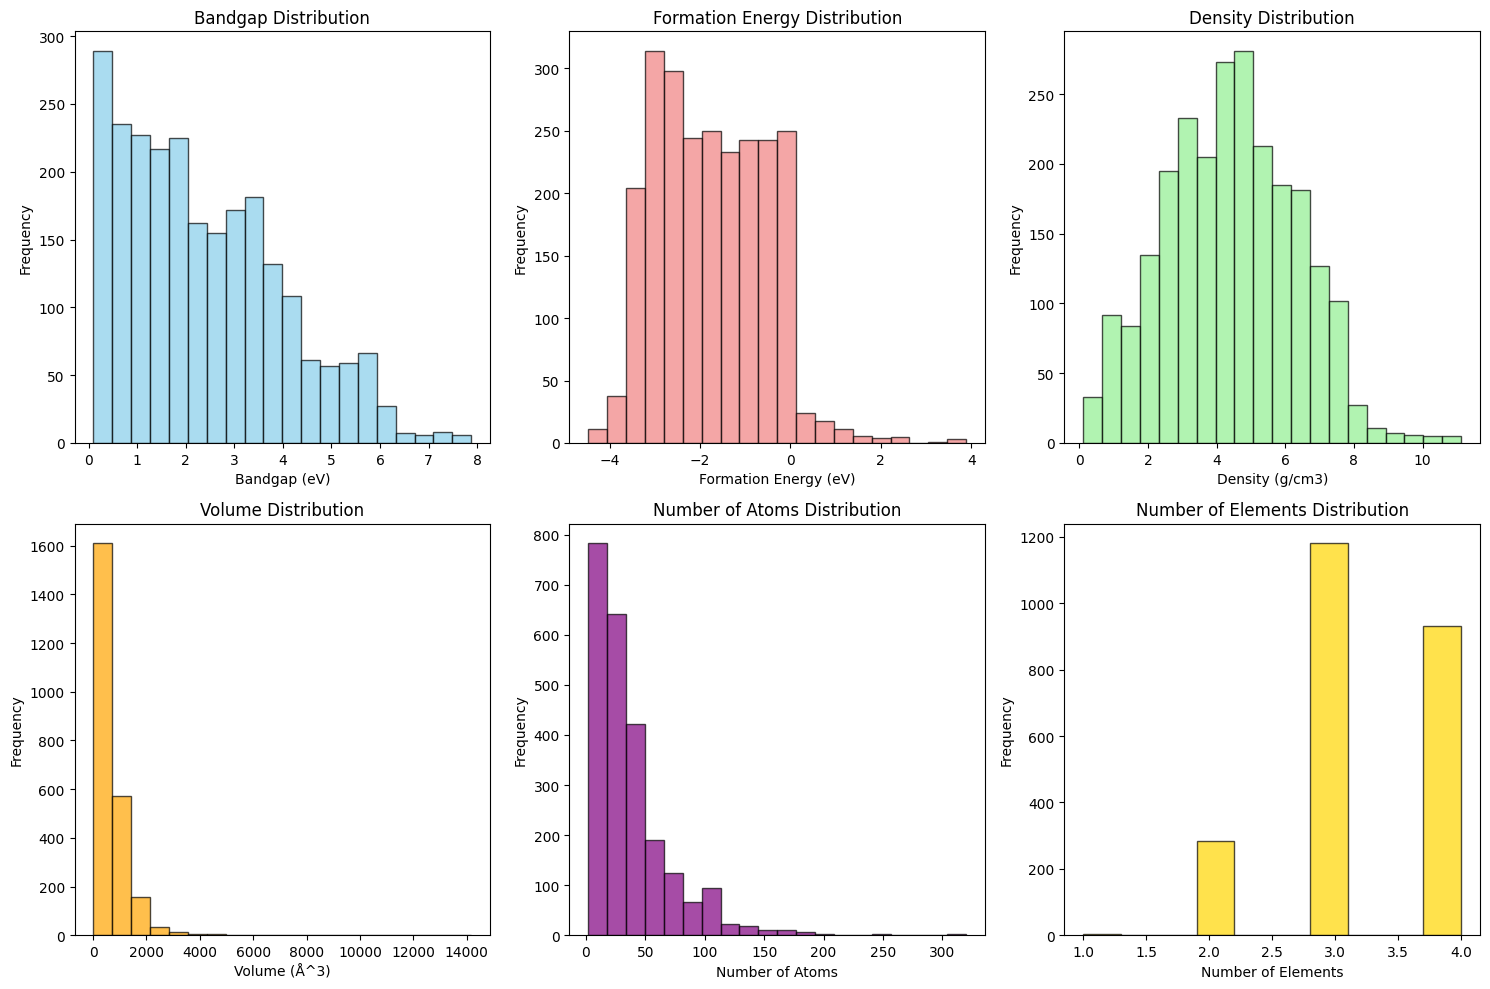

In [5]:
# --- 2. 数据分布可视化 / Visualize Train Data Distributions ---
# 创建一个 2行3列 的画布 / Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# [0,0] 带隙分布（目标变量）/ Bandgap distribution (target variable)
axes[0,0].hist(train_df['bandgap_eV'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Bandgap Distribution')
axes[0,0].set_xlabel('Bandgap (eV)')
axes[0,0].set_ylabel('Frequency')

# [0,1] 形成能分布 / Formation energy distribution
axes[0,1].hist(train_df['formation_energy'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Formation Energy Distribution')
axes[0,1].set_xlabel('Formation Energy (eV)')
axes[0,1].set_ylabel('Frequency')

# [0,2] 密度分布 / Density distribution
axes[0,2].hist(train_df['density_gcc'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,2].set_title('Density Distribution')
axes[0,2].set_xlabel('Density (g/cm3)')
axes[0,2].set_ylabel('Frequency')

# [1,0] 体积分布 / Volume distribution
axes[1,0].hist(train_df['volume_A3'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('Volume Distribution')
axes[1,0].set_xlabel('Volume (Å^3)')
axes[1,0].set_ylabel('Frequency')

# [1,1] 原子数量分布 / Number of atoms distribution
axes[1,1].hist(train_df['n_atoms'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_title('Number of Atoms Distribution')
axes[1,1].set_xlabel('Number of Atoms')
axes[1,1].set_ylabel('Frequency')

# [1,2] 元素种类分布 / Number of elements distribution
axes[1,2].hist(train_df['n_elements'], bins=10, alpha=0.7, color='gold', edgecolor='black')
axes[1,2].set_title('Number of Elements Distribution')
axes[1,2].set_xlabel('Number of Elements')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout() # 自动调整子图间距 / Adjust layout to prevent overlap
plt.show()

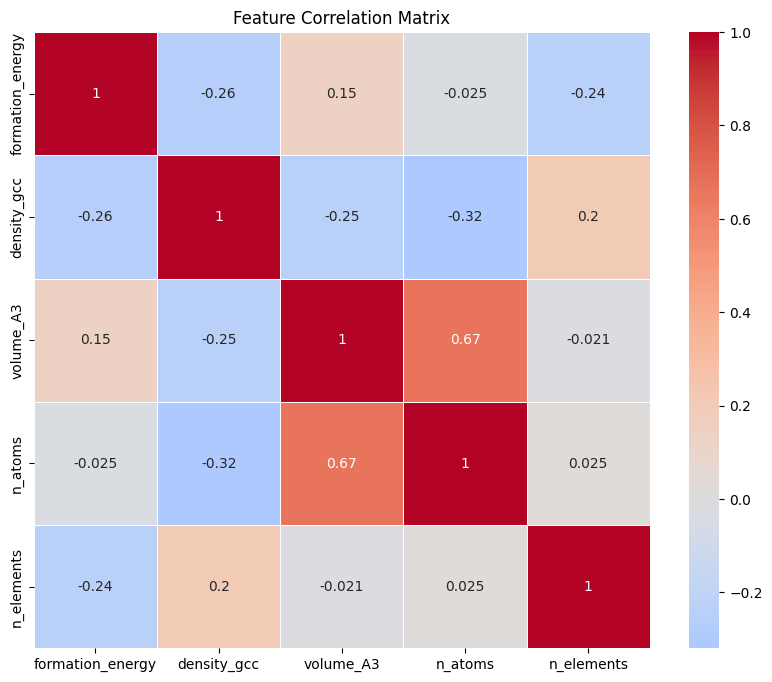

In [6]:
# Correlation Matrix
plt.figure(figsize=(10, 8))

# 自动筛选数值型列 / Automatically select numerical columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# 按照 Screenshot 6 的要求，在分析特征间相关性时剔除目标变量
# Remove the target variable to analyze feature-only correlation
numeric_cols_for_corr = numeric_cols.drop('bandgap_eV')

# 计算相关系数矩阵 / Calculate correlation matrix
correlation_matrix = train_df[numeric_cols_for_corr].corr()

# 使用热力图可视化相关性 / Visualize with a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# **2.3 Feature Engineering with Materials Informatics**

In [7]:
# --- 2. 准备特征提取副本 / Prepare a working copy for featurization ---
# 使用 train_df 的副本进行特征工程，避免修改原始数据
# Create a copy of train_df to avoid modifying the original training data
feature_df = train_df.copy()

# --- 3. 将成分字符串转换为 pymatgen 对象 / Convert strings to Composition objects ---
# ML 模型无法直接处理 "Ac2O3" 字符串，需要先转换为 pymatgen 对象
# Models cannot handle "Ac2O3" strings directly; they must be converted to objects
stc = StrToComposition(target_col_id='composition_obj')
# featurize_dataframe 会在 df 中新增一列 'composition_obj'
feature_df = stc.featurize_dataframe(feature_df, "composition")

print(f"Dataset shape after composition conversion: {feature_df.shape}")

# --- 4. 初始化选定的特征提取器 / Initialize selected featurizers ---
# 选取几个经典的特征描述符，平衡模型精度与计算复杂度
# Selected key descriptors to balance model accuracy and computational complexity
featurizers = [
    cf.ElementProperty.from_preset("magpie"), # 提取元素的物理/化学属性 (如原子半径、电负性) / Elemental properties
    cf.Stoichiometry(),                      # 提取化学计量的统计特征 (如原子数占比) / Stoichiometric features
    cf.ElementFraction(),                    # 提取每个元素在材料中的分数 / Element fraction features
    cf.TMetalFraction(),                     # 提取过渡金属的占比 / Transition metal fraction
]

# --- 5. 逐个应用特征提取器 / Apply featurizers one by one ---
print("Applying featurizers...")

for i, featurizer in enumerate(featurizers):
    try:
        # 打印当前进度和正在运行的提取器类名
        print(f"Applying featurizer {i+1}/{len(featurizers)}: {featurizer.__class__.__name__}")

        # 将特征添加到 feature_df 中，忽略提取过程中的个别错误
        # Add features to dataframe, use ignore_errors=True to skip problematic entries
        feature_df = featurizer.featurize_dataframe(feature_df, col_id="composition_obj", ignore_errors=True)

        print(f"Shape after {featurizer.__class__.__name__}: {feature_df.shape}")
    except Exception as e:
        print(f"Error with featurizer {featurizer.__class__.__name__}: {e}")
        continue

print(f"Final dataset shape after featurization: {feature_df.shape}")

# --- 6. 清理并提取特征矩阵 / Clean and extract feature matrix ---
# 移除原始的字符串和对象列，只保留数值型特征
# Remove non-numeric columns like formula strings and composition objects
non_feature_cols = ['composition', 'pretty_formula', 'composition_obj', 'material_id', 'formula']
# 筛选出所有数值类型的列 / Select columns with numerical data types
feature_cols = [col for col in feature_df.columns if col not in non_feature_cols]
numeric_features = feature_df[feature_cols].select_dtypes(include=[np.number])

print(f"Number of numeric features: {numeric_features.shape[1]}")

# --- 7. 数据清洗：处理无效值 / Clean the dataset: Handle inf and NaN ---
# 机器学习模型无法处理无穷大或缺失值，此处用中位数填充
# ML models cannot handle infinite or missing values; fill them with median
numeric_features = numeric_features.replace([np.inf, -np.inf], np.nan)
numeric_features = numeric_features.fillna(numeric_features.median())

# --- 8. 划分目标变量和特征矩阵 / Separate target and features ---
# 目标变量 y 为带隙，特征矩阵 X 为其余所有数值特征
# Target y is the bandgap; feature matrix X includes all other numerical descriptors
y = numeric_features['bandgap_eV'].copy()
X = numeric_features.drop(['bandgap_eV'], axis=1)

print(f"Target variable shape: {y.shape}")
print(f"Feature matrix shape: {X.shape}")
# 显示前 10 个提取出的物理特征名称 / Show names of the first 10 descriptors
print(f"Sample features: {list(X.columns[:10])}")

StrToComposition:   0%|          | 0/2400 [00:00<?, ?it/s]

Dataset shape after composition conversion: (2400, 10)
Applying featurizers...
Applying featurizer 1/4: ElementProperty


ElementProperty:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after ElementProperty: (2400, 142)
Applying featurizer 2/4: Stoichiometry


Stoichiometry:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after Stoichiometry: (2400, 148)
Applying featurizer 3/4: ElementFraction


ElementFraction:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after ElementFraction: (2400, 266)
Applying featurizer 4/4: TMetalFraction


TMetalFraction:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after TMetalFraction: (2400, 267)
Final dataset shape after featurization: (2400, 267)
Number of numeric features: 263
Target variable shape: (2400,)
Feature matrix shape: (2400, 262)
Sample features: ['formation_energy', 'density_gcc', 'volume_A3', 'n_atoms', 'n_elements', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number']


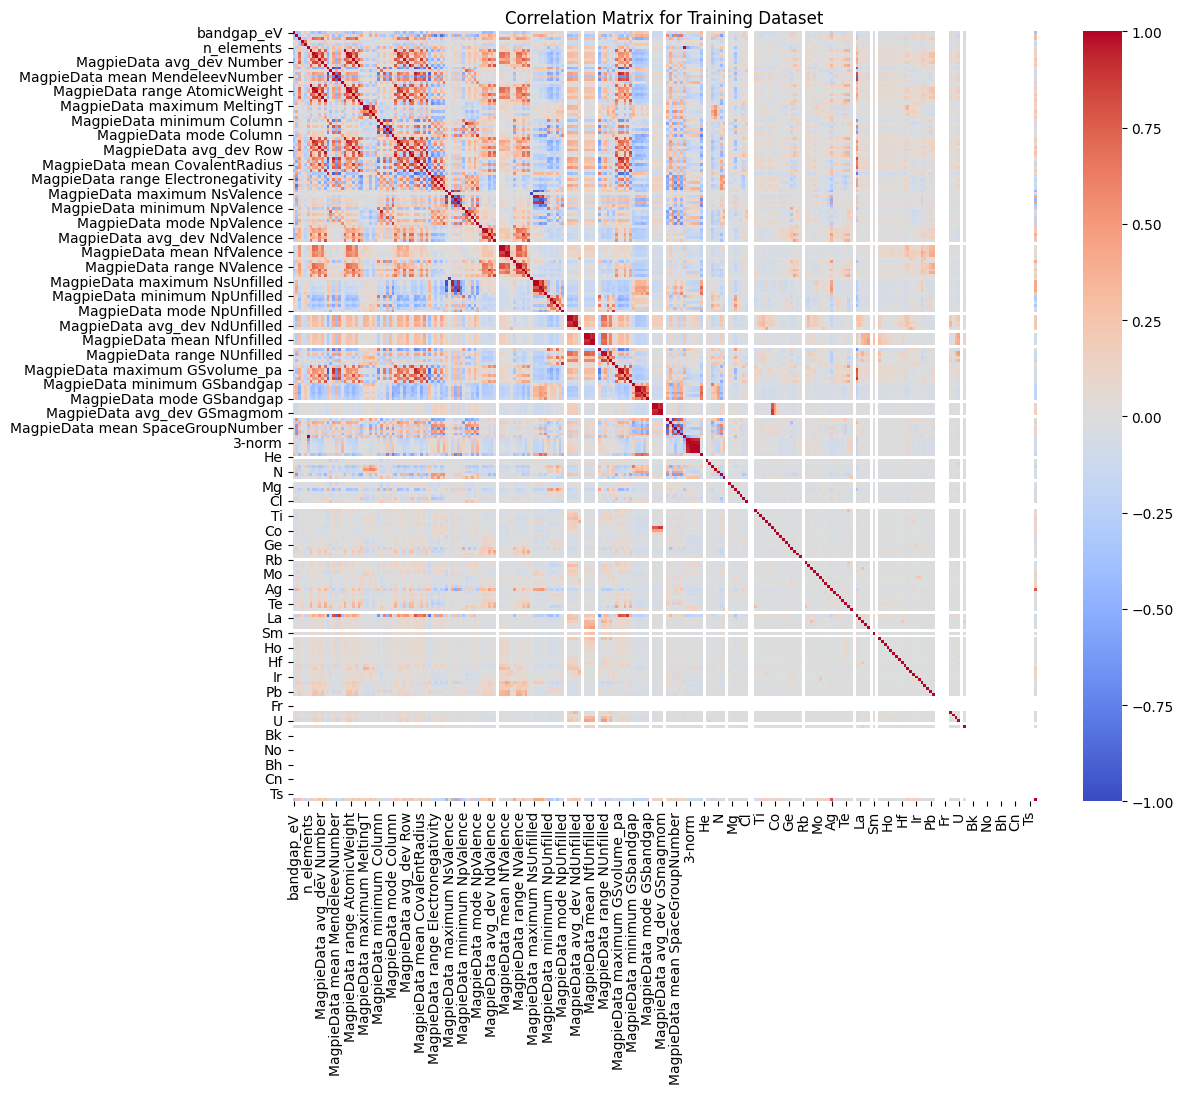


Highest correlations with bandgap_eV:
bandgap_eV                           1.000000
MagpieData mean Row                  0.476448
MagpieData mean CovalentRadius       0.451637
MagpieData mean Number               0.447946
MagpieData mean AtomicWeight         0.438877
MagpieData maximum NdValence         0.438561
MagpieData avg_dev NdValence         0.436316
MagpieData minimum CovalentRadius    0.423174
MagpieData mean NdValence            0.420331
MagpieData mode CovalentRadius       0.399672
Name: bandgap_eV, dtype: float64


In [8]:
# Feature Correlation Matrix
plt.figure(figsize=(12, 10))
# 计算所有特征之间的相关系数 / Calculate correlation matrix
correlation_matrix = numeric_features.corr()

# 绘制热力图以检查特征间是否存在过高的相关性（多重共线性）
# Draw heatmap to check for multicollinearity between features
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Training Dataset')
plt.show()

# --- 9. 寻找与带隙相关性最强的特征 / Highest correlations with bandgap ---
print("\nHighest correlations with bandgap_eV:")
# 计算所有特征与带隙的相关性绝对值并排序
# Sort features by absolute correlation with the target
bandgap_correlations = correlation_matrix['bandgap_eV'].abs().sort_values(ascending=False)
print(bandgap_correlations.head(10))

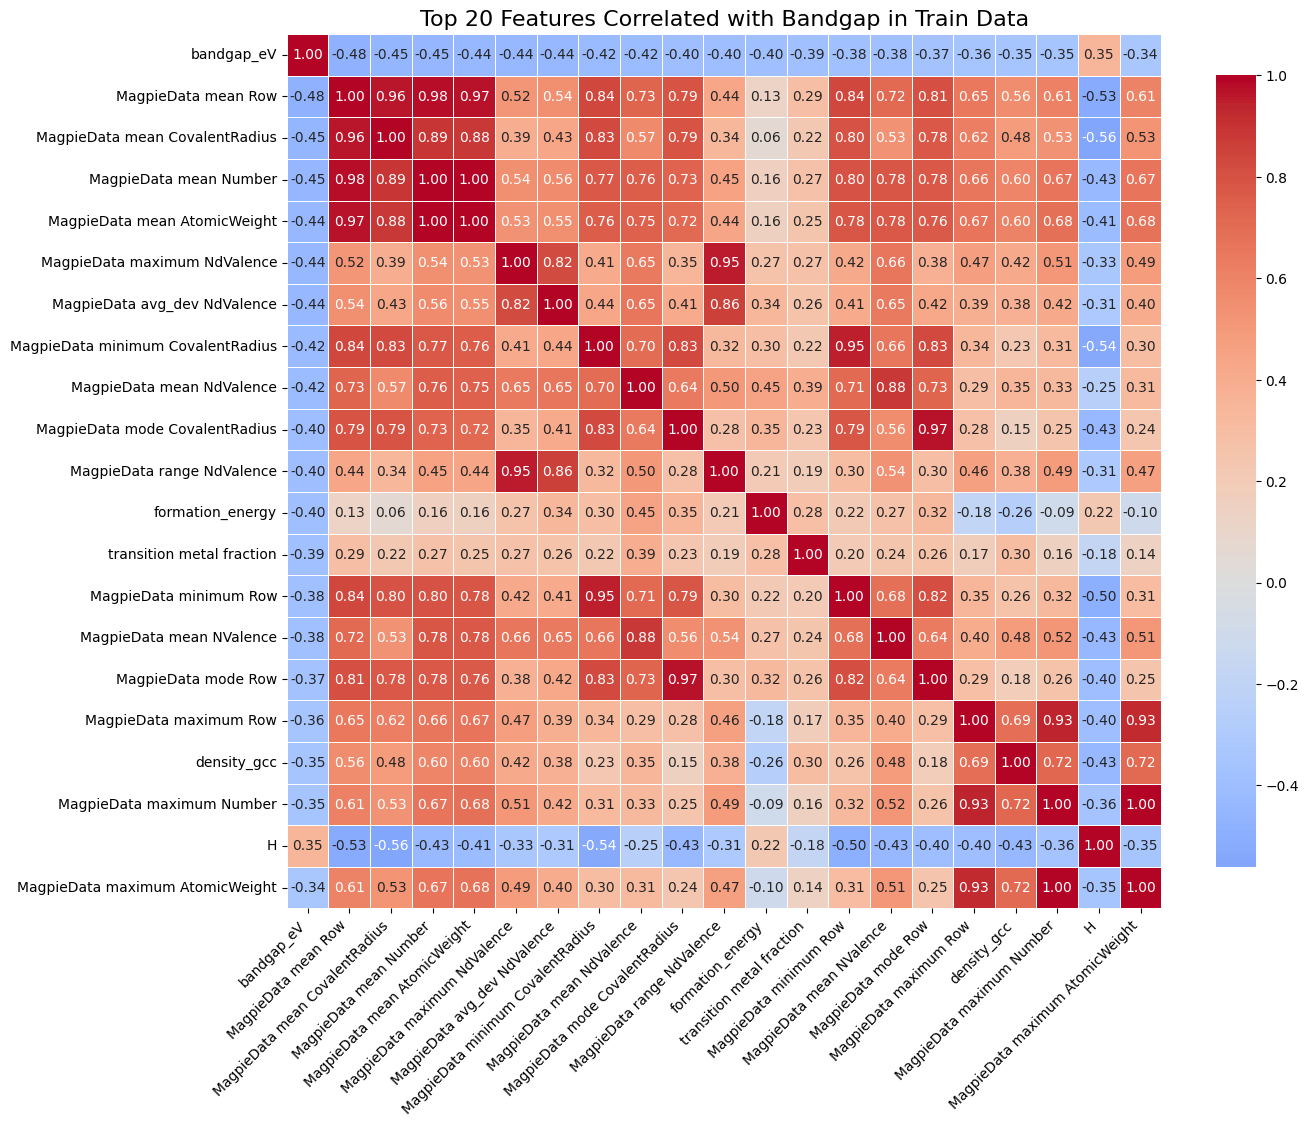


Highest correlations with bandgap_eV:
bandgap_eV                           1.000000
MagpieData mean Row                  0.476448
MagpieData mean CovalentRadius       0.451637
MagpieData mean Number               0.447946
MagpieData mean AtomicWeight         0.438877
MagpieData maximum NdValence         0.438561
MagpieData avg_dev NdValence         0.436316
MagpieData minimum CovalentRadius    0.423174
MagpieData mean NdValence            0.420331
MagpieData mode CovalentRadius       0.399672
Name: bandgap_eV, dtype: float64


In [13]:
# --- 1. Identify the top 20 most correlated features / 筛选相关性最高的前20个特征 ---
# Calculate the absolute correlation with the target variable 'bandgap_eV'
# 这里的目的是找到与带隙相关性绝对值最大的特征（正相关或负相关都重要）
target_corr = numeric_features.corr()['bandgap_eV'].abs().sort_values(ascending=False)

# Select the top 20 features (excluding 'bandgap_eV' itself at index 0)
# 取前21个，因为第1个通常是 bandgap_eV 自身 (相关性为 1.0)
top_20_features = target_corr.head(21).index

# --- 2. Create the filtered correlation matrix / 创建筛选后的相关系数矩阵 ---
# Filter the dataframe to only include these top 20 descriptors + target
filtered_corr_matrix = numeric_features[top_20_features].corr()

# --- 3. Plot the Heatmap / 绘制精简版热图 ---
plt.figure(figsize=(14, 12))

# Using 'annot=True' to show values since we only have 20 columns now
# 因为现在只有20列，我们可以开启标注 (annot) 来直接读取数值
sns.heatmap(
    filtered_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title('Top 20 Features Correlated with Bandgap in Train Data', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability / 旋转标签方便阅读
plt.tight_layout()
plt.show()

# --- 9. 寻找与带隙相关性最强的特征 / Highest correlations with bandgap ---
print("\nHighest correlations with bandgap_eV:")
# 计算所有特征与带隙的相关性绝对值并排序
# Sort features by absolute correlation with the target
bandgap_correlations = correlation_matrix['bandgap_eV'].abs().sort_values(ascending=False)
print(bandgap_correlations.head(10))